In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
from scipy.spatial.distance import cdist

In [ ]:
# Manual Implementation of Isolation Forest
class IsolationTreeNode:
    def __init__(self, depth=0, max_depth=10):
        self.depth = depth
        self.max_depth = max_depth
        self.split_feature = None
        self.split_value = None
        self.left = None
        self.right = None
        self.size = 0

    def fit(self, X):
        n_samples, n_features = X.shape
        self.size = n_samples

        # Termination criteria
        if self.depth >= self.max_depth or n_samples <= 1:
            return

        # Randomly select feature
        self.split_feature = random.randint(0, n_features-1)

        # Find min and max values for the selected feature
        x_min = np.min(X[:, self.split_feature])
        x_max = np.max(X[:, self.split_feature])

        # If all values are the same, terminate
        if x_min == x_max:
            return

        # Randomly select split value
        self.split_value = np.random.uniform(x_min, x_max)

        # Split data
        left_indices = X[:, self.split_feature] < self.split_value
        right_indices = ~left_indices

        # Create child nodes
        if np.any(left_indices):
            self.left = IsolationTreeNode(depth=self.depth+1, max_depth=self.max_depth)
            self.left.fit(X[left_indices])

        if np.any(right_indices):
            self.right = IsolationTreeNode(depth=self.depth+1, max_depth=self.max_depth)
            self.right.fit(X[right_indices])

    def path_length(self, x):
        if self.left is None and self.right is None:
            # Average path length for unsuccessful search in a BST
            return self.depth + c(self.size)

        if x[self.split_feature] < self.split_value:
            if self.left is None:
                return self.depth + c(self.size)
            return self.left.path_length(x)
        else:
            if self.right is None:
                return self.depth + c(self.size)
            return self.right.path_length(x)

def c(size):
    """Helper function for average path length calculation"""
    if size <= 1:
        return 0
    return 2.0 * (np.log(size - 1) + 0.5772156649) - (2.0 * (size - 1) / size)

class ManualIsolationForest:
    def __init__(self, n_estimators=100, max_samples=256, contamination=0.1):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.contamination = contamination
        self.trees = []
        self.threshold = None

    def fit(self, X):
        n_samples = X.shape[0]
        sample_size = min(self.max_samples, n_samples)

        # Grow isolation trees
        for i in range(self.n_estimators):
            # Randomly sample data
            indices = np.random.choice(n_samples, sample_size, replace=False)
            X_sampled = X[indices]

            # Build a tree
            tree = IsolationTreeNode()
            tree.fit(X_sampled)
            self.trees.append(tree)

        # Calculate anomaly scores for setting threshold
        scores = self.decision_function(X)
        self.threshold = np.percentile(scores, 100 * self.contamination)

        return self

    def decision_function(self, X):
        # Higher score means more normal (less anomalous)
        avg_path_lengths = np.zeros(X.shape[0])

        for tree in self.trees:
            for i, x in enumerate(X):
                path_length = tree.path_length(x)
                avg_path_lengths[i] += path_length

        avg_path_lengths /= self.n_estimators

        # Convert path length to anomaly score
        # Shorter paths are more anomalous
        n_samples = X.shape[0]
        expected_path_length = 2.0 * (np.log(n_samples - 1) + 0.5772156649) - (2.0 * (n_samples - 1) / n_samples)
        scores = 2 ** (-avg_path_lengths / expected_path_length)

        # Negate scores so higher values are more anomalous
        return -scores

    def predict(self, X):
        scores = self.decision_function(X)
        return np.where(scores >= self.threshold, -1, 1)


# Manual Implementation of Local Outlier Factor (LOF)
class ManualLOF:
    def __init__(self, n_neighbors=20, contamination=0.1):
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.X_train = None
        self.k_distances = None
        self.k_neighbors = None
        self.local_reachability_density = None
        self.threshold = None

    def fit(self, X):
        self.X_train = X
        n_samples = X.shape[0]

        # Calculate pairwise distances
        distances = cdist(X, X)

        # Get k nearest neighbors and their distances
        self.k_neighbors = np.zeros((n_samples, self.n_neighbors), dtype=int)
        self.k_distances = np.zeros((n_samples, self.n_neighbors))

        for i in range(n_samples):
            # Sort distances for each sample
            # Skip the first one as it's the distance to itself (0)
            idx = np.argsort(distances[i])[1:self.n_neighbors+1]
            self.k_neighbors[i] = idx
            self.k_distances[i] = distances[i, idx]

        # Calculate reachability distance
        # reachability_distance(a,b) = max(k-distance(b), distance(a,b))
        reachability_distances = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(n_samples):
                if i == j:
                    reachability_distances[i, j] = 0
                else:
                    # k-distance of j is the distance to its k-th neighbor
                    k_dist_j = self.k_distances[j, -1]
                    reachability_distances[i, j] = max(k_dist_j, distances[i, j])

        # Calculate local reachability density (LRD)
        # LRD = 1 / average reachability distance to k neighbors
        self.local_reachability_density = np.zeros(n_samples)

        for i in range(n_samples):
            neighbors = self.k_neighbors[i]
            avg_reachability = np.mean([reachability_distances[i, j] for j in neighbors])
            if avg_reachability > 0:
                self.local_reachability_density[i] = 1.0 / avg_reachability
            else:
                self.local_reachability_density[i] = float('inf')

        # Calculate LOF scores
        lof_scores = np.zeros(n_samples)

        for i in range(n_samples):
            neighbors = self.k_neighbors[i]
            lrd_ratios = np.array([self.local_reachability_density[j] / self.local_reachability_density[i]
                                  for j in neighbors])
            lof_scores[i] = np.mean(lrd_ratios)

        # Set threshold
        self.threshold = np.percentile(lof_scores, 100 * (1 - self.contamination))

        return self

    def decision_function(self, X):
        if self.X_train is None:
            raise ValueError("Model is not fitted yet.")

        n_samples = X.shape[0]
        lof_scores = np.zeros(n_samples)

        # Calculate distances to training points
        distances = cdist(X, self.X_train)

        for i in range(n_samples):
            # Find k nearest neighbors in training set
            nn_indices = np.argsort(distances[i])[:self.n_neighbors]
            nn_distances = distances[i, nn_indices]

            # Calculate reachability distances
            reach_dists = np.array([max(self.k_distances[j, -1], distances[i, j])
                                   for j in nn_indices])

            # Calculate LRD
            if np.mean(reach_dists) > 0:
                lrd = 1.0 / np.mean(reach_dists)
            else:
                lrd = float('inf')

            # Calculate LOF
            neighbor_lrds = np.array([self.local_reachability_density[j] for j in nn_indices])
            lof_scores[i] = np.mean(neighbor_lrds / lrd)

        return lof_scores

    def predict(self, X):
        scores = self.decision_function(X)
        return np.where(scores > self.threshold, -1, 1)

In [ ]:
def compare_implementations(train_df, val_df, test_df, numerical_cols, categorical_cols, preprocessor, contamination=0.05):
    """Compare manual and scikit-learn implementations of anomaly detection algorithms"""
    print("\n--- Comparing manual and scikit-learn implementations ---")

    # Process the data
    X_train = preprocessor.fit_transform(train_df[numerical_cols + categorical_cols])
    X_val = preprocessor.transform(val_df[numerical_cols + categorical_cols])
    X_test = preprocessor.transform(test_df[numerical_cols + categorical_cols])

    # 1. Manual Implementations
    print("Training manual implementations...")

    # Isolation Forest
    manual_iforest = ManualIsolationForest(n_estimators=50, contamination=contamination)
    try:
        # Use a small subset for faster training (manual implementation is slower)
        sample_size = min(5000, X_train.shape[0])
        sampled_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
        manual_iforest.fit(X_train[sampled_indices])
        manual_if_scores = manual_iforest.decision_function(X_test)
        manual_if_preds = manual_iforest.predict(X_test)
        manual_if_trained = True
        print("  Manual Isolation Forest trained successfully")
    except Exception as e:
        print(f"  Error in manual Isolation Forest: {e}")
        manual_if_trained = False

    # LOF
    manual_lof = ManualLOF(n_neighbors=20, contamination=contamination)
    try:
        # Use a small subset for faster training
        sample_size = min(2000, X_train.shape[0])
        sampled_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
        manual_lof.fit(X_train[sampled_indices])
        manual_lof_scores = manual_lof.decision_function(X_test)
        manual_lof_preds = manual_lof.predict(X_test)
        manual_lof_trained = True
        print("  Manual LOF trained successfully")
    except Exception as e:
        print(f"  Error in manual LOF: {e}")
        manual_lof_trained = False

    # 2. Scikit-learn Implementations
    print("Training scikit-learn implementations...")

    # Isolation Forest
    sklearn_iforest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    sklearn_iforest.fit(X_train)
    sklearn_if_scores = sklearn_iforest.decision_function(X_test)
    sklearn_if_preds = sklearn_iforest.predict(X_test)

    # LOF
    sklearn_lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)
    sklearn_lof.fit(X_train)
    sklearn_lof_scores = sklearn_lof.score_samples(X_test)
    sklearn_lof_preds = sklearn_lof.predict(X_test)

    # 3. Evaluate and compare
    print("\nComparison results:")

    # Compare if manual implementations were successful
    if manual_if_trained:
        if_agreement = np.mean(manual_if_preds == sklearn_if_preds)
        if_score_corr = np.corrcoef(manual_if_scores, sklearn_if_scores)[0, 1]
        print(f"  Isolation Forest - Prediction agreement: {if_agreement:.4f}")
        print(f"  Isolation Forest - Score correlation: {if_score_corr:.4f}")
        print(f"  Manual IF anomalies: {np.sum(manual_if_preds == -1)} ({np.mean(manual_if_preds == -1)*100:.2f}%)")

    if manual_lof_trained:
        lof_agreement = np.mean(manual_lof_preds == sklearn_lof_preds)
        # For LOF, sklearn returns negative of what our manual implementation returns
        lof_score_corr = np.corrcoef(manual_lof_scores, -sklearn_lof_scores)[0, 1]
        print(f"  LOF - Prediction agreement: {lof_agreement:.4f}")
        print(f"  LOF - Score correlation: {lof_score_corr:.4f}")
        print(f"  Manual LOF anomalies: {np.sum(manual_lof_preds == -1)} ({np.mean(manual_lof_preds == -1)*100:.2f}%)")

    # Compare scikit-learn implementations
    print(f"  Scikit-learn IF anomalies: {np.sum(sklearn_if_preds == -1)} ({np.mean(sklearn_if_preds == -1)*100:.2f}%)")
    print(f"  Scikit-learn LOF anomalies: {np.sum(sklearn_lof_preds == -1)} ({np.mean(sklearn_lof_preds == -1)*100:.2f}%)")

    # 4. Create visualizations for comparison
    plt.figure(figsize=(15, 10))

    # Scatter plot of anomaly scores
    plt.subplot(2, 2, 1)
    if manual_if_trained:
        plt.scatter(sklearn_if_scores, manual_if_scores, alpha=0.5)
        plt.xlabel('Scikit-learn IF Scores')
        plt.ylabel('Manual IF Scores')
        plt.title('Isolation Forest Scores Comparison')
        plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    if manual_lof_trained:
        plt.scatter(-sklearn_lof_scores, manual_lof_scores, alpha=0.5)
        plt.xlabel('Scikit-learn LOF Scores')
        plt.ylabel('Manual LOF Scores')
        plt.title('LOF Scores Comparison')
        plt.grid(True, alpha=0.3)

    # Distribution of anomaly scores
    plt.subplot(2, 2, 3)
    if manual_if_trained:
        plt.hist(manual_if_scores, bins=50, alpha=0.5, label='Manual')
    plt.hist(sklearn_if_scores, bins=50, alpha=0.5, label='Scikit-learn')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Isolation Forest Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    if manual_lof_trained:
        plt.hist(manual_lof_scores, bins=50, alpha=0.5, label='Manual')
    plt.hist(-sklearn_lof_scores, bins=50, alpha=0.5, label='Scikit-learn')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('LOF Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('implementation_comparison.png')
    print("\nComparison visualization saved as 'implementation_comparison.png'")

    return {
        'sklearn_if_scores': sklearn_if_scores,
        'sklearn_lof_scores': sklearn_lof_scores,
        'manual_if_scores': manual_if_scores if manual_if_trained else None,
        'manual_lof_scores': manual_lof_scores if manual_lof_trained else None,
        'if_agreement': if_agreement if manual_if_trained else None,
        'lof_agreement': lof_agreement if manual_lof_trained else None
    }

In [ ]:
# -*- coding: utf-8 -*-
"""MLPhase2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1ifyr0CPvAArPg-upGrEYr6DJFxrhCag9

1
"""


# 1. Load and preprocess the data
def load_data(file_path):
    """
    Load data from CSV and perform initial preprocessing
    """
    print("Loading data from:", file_path)
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df):
    """
    Preprocess the data by:
    - Handling missing values
    - Converting timestamp to datetime
    - Extracting time-based features
    """
    print("\n--- Starting data preprocessing ---")

    # Make a copy to avoid modifying the original
    df_processed = df.copy()

    # Check for missing values
    print("\nMissing values before handling:")
    print(df_processed.isnull().sum())

    # Fill missing values - specific handling for each column
    if 'Amount' in df_processed.columns:
        # For amounts, use the median (more robust to outliers than mean)
        df_processed['Amount'] = df_processed['Amount'].fillna(df_processed['Amount'].median())

    if 'Merchant' in df_processed.columns:
        # For categorical, use the most frequent value
        df_processed['Merchant'] = df_processed['Merchant'].fillna(df_processed['Merchant'].mode()[0])

    if 'TransactionType' in df_processed.columns:
        df_processed['TransactionType'] = df_processed['TransactionType'].fillna(df_processed['TransactionType'].mode()[0])

    if 'Location' in df_processed.columns:
        df_processed['Location'] = df_processed['Location'].fillna(df_processed['Location'].mode()[0])

    # Process the timestamp column - handle the format error you encountered
    if 'Timestamp' in df_processed.columns:
        print("\nHandling Timestamp column...")
        try:
            # First check the format of timestamps
            example_timestamp = df_processed['Timestamp'].iloc[0]
            print(f"Example timestamp: {example_timestamp}")

            # Try to parse with seconds
            try:
                df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], format='%d-%m-%Y %H:%M:%S')
                print("Parsed timestamps with seconds format")
            except ValueError:
                # If fails, try without seconds
                try:
                    df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], format='%d-%m-%Y %H:%M')
                    print("Parsed timestamps without seconds format")
                except ValueError:
                    # If still failing, use a more flexible approach
                    df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'], dayfirst=True)
                    print("Used flexible datetime parsing")

            # Extract useful time features
            df_processed['Hour'] = df_processed['Timestamp'].dt.hour
            df_processed['Day'] = df_processed['Timestamp'].dt.day
            df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
            df_processed['Month'] = df_processed['Timestamp'].dt.month
            df_processed['Weekend'] = df_processed['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 are weekend days

            # Add a feature for business hours (9 AM to 5 PM, Monday to Friday)
            df_processed['BusinessHours'] = ((df_processed['Hour'] >= 9) &
                                           (df_processed['Hour'] <= 17) &
                                           (df_processed['DayOfWeek'] < 5)).astype(int)

            print("Created time-based features: Hour, Day, DayOfWeek, Month, Weekend, BusinessHours")
        except Exception as e:
            print(f"Error processing timestamps: {e}")
            # If timestamp processing fails, create a dummy column to avoid breaking the pipeline
            df_processed['Hour'] = 0
            df_processed['Day'] = 0
            df_processed['DayOfWeek'] = 0
            df_processed['Month'] = 0
            df_processed['Weekend'] = 0
            df_processed['BusinessHours'] = 0

    # Ensure no missing values remain
    print("\nChecking for remaining missing values...")
    for column in df_processed.columns:
        if df_processed[column].isnull().sum() > 0:
            print(f"Filling remaining NA values in {column}")
            if df_processed[column].dtype == 'object':
                df_processed[column] = df_processed[column].fillna('Unknown')
            else:
                df_processed[column] = df_processed[column].fillna(0)

    print("\nMissing values after handling:")
    print(df_processed.isnull().sum())

    print("\nShape after preprocessing:", df_processed.shape)
    return df_processed

# 2. Feature Engineering
def engineer_features(df):
    """
    Create additional features that might help detect fraud:
    - Transaction frequency metrics
    - Amount statistics by account
    - Behavioral patterns
    """
    print("\n--- Starting feature engineering ---")
    df_featured = df.copy()

    # Group transactions by account
    if 'AccountID' in df_featured.columns and 'Amount' in df_featured.columns:
        print("Creating account-based features...")

        # Transaction amount statistics per account
        account_stats = df_featured.groupby('AccountID')['Amount'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
        account_stats.columns = ['AccountID', 'Avg_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount', 'Tx_Count']

        # Merge stats back to main dataframe
        df_featured = pd.merge(df_featured, account_stats, on='AccountID', how='left')

        # Calculate amount ratio (current amount / average amount for that account)
        # This helps identify transactions that are unusually large for a particular account
        df_featured['Amount_Ratio'] = df_featured['Amount'] / df_featured['Avg_Amount']

        # Replace infinity values (caused by division by zero) with a large number
        df_featured['Amount_Ratio'] = df_featured['Amount_Ratio'].replace([np.inf, -np.inf], 999)

        # Fill NaN values that might have been created
        df_featured['Amount_Ratio'] = df_featured['Amount_Ratio'].fillna(1)

        print("Created account-based features: Avg_Amount, Std_Amount, Min_Amount, Max_Amount, Tx_Count, Amount_Ratio")

    # Create time-window based features if timestamp is available
    if 'Timestamp' in df_featured.columns:
        print("Creating time-window based features...")

        # First check if Timestamp is already a datetime or needs conversion
        if not pd.api.types.is_datetime64_any_dtype(df_featured['Timestamp']):
            try:
                # Try to convert if it's not already datetime
                df_featured['Timestamp'] = pd.to_datetime(df_featured['Timestamp'], dayfirst=True)
                print("Converted Timestamp to datetime format")
            except Exception as e:
                print(f"Could not convert timestamps to datetime: {e}")
                print("Skipping time-window features that require datetime")
                return df_featured

        try:
            # Sort by timestamp - handle case where some timestamps might be missing
            df_featured = df_featured.copy()  # Avoid SettingWithCopyWarning
            df_featured.sort_values(['AccountID', 'Timestamp'], inplace=True)

            # Calculate time difference between consecutive transactions for the same account
            df_featured['Prev_Tx_Time'] = df_featured.groupby('AccountID')['Timestamp'].shift(1)

            # Convert to numeric hours, handling NaT values
            df_featured['Time_Since_Last_Tx'] = pd.to_numeric(
                (df_featured['Timestamp'] - df_featured['Prev_Tx_Time']).dt.total_seconds(),
                errors='coerce'
            ) / 3600  # convert seconds to hours

            # Fill NaN values (first transaction for each account or conversion errors)
            df_featured['Time_Since_Last_Tx'] = df_featured['Time_Since_Last_Tx'].fillna(24)  # assume 24 hours for first transaction

            # Flag rapid succession transactions safely
            # Convert to numeric type first to avoid comparison issues
            df_featured['Rapid_Succession'] = (df_featured['Time_Since_Last_Tx'] < 1).astype(int)  # less than 1 hour

            print("Created time-window features: Time_Since_Last_Tx, Rapid_Succession")
        except Exception as e:
            print(f"Error creating time-window features: {e}")
            print("Continuing without time-window features")
            # Create dummy columns to avoid breaking the pipeline
            df_featured['Time_Since_Last_Tx'] = 24  # default value
            df_featured['Rapid_Succession'] = 0     # default value

    # Create location-based features if available
    if 'Location' in df_featured.columns:
        print("Creating location-based features...")

        try:
            # Get most common location for each account - safer approach
            account_locations = df_featured.groupby('AccountID')['Location'].apply(
                lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else "Unknown"
            ).reset_index()
            account_locations.columns = ['AccountID', 'Common_Location']

            # Ensure no NaN/None values in the locations before comparison
            df_featured['Location'] = df_featured['Location'].fillna("Unknown")

            # Merge back to main dataframe
            df_featured = pd.merge(df_featured, account_locations, on='AccountID', how='left')

            # Handle any missing values from the merge
            df_featured['Common_Location'] = df_featured['Common_Location'].fillna(df_featured['Location'])

            # Flag transactions not in the common location for an account
            df_featured['Location_Change'] = (df_featured['Location'] != df_featured['Common_Location']).astype(int)

            print("Created location-based feature: Location_Change")
        except Exception as e:
            print(f"Error creating location-based features: {e}")
            print("Continuing without location-based features")
            # Create dummy column to avoid breaking the pipeline
            df_featured['Location_Change'] = 0  # default value

    # Handle categorical variables - we'll do one-hot encoding later in the pipeline

    print("\nFeature engineering completed. New dataframe shape:", df_featured.shape)
    print("\nNew features created:")
    new_features = set(df_featured.columns) - set(df.columns)
    print(list(new_features))

    return df_featured

# 3. Split the dataset into train, test, and validation sets
def split_data(df, target_col=None):
    """
    Split the data into training, validation, and test sets
    For unsupervised learning, we don't have a target but we still split to evaluate performance
    """
    print("\n--- Splitting dataset ---")

    try:
        # Reset index to avoid any issues with duplicated indices
        df = df.reset_index(drop=True)

        # Make a copy to avoid SettingWithCopyWarning
        df_copy = df.copy()

        # First split into training (70%) and temp (30%)
        train_df, temp_df = train_test_split(df_copy, test_size=0.3, random_state=42)

        # Then split temp into validation (10% of original) and test (20% of original)
        # This is 1/3 and 2/3 of temp respectively
        val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42)

        print(f"Training set: {train_df.shape[0]} records ({train_df.shape[0]/df.shape[0]*100:.1f}%)")
        print(f"Validation set: {val_df.shape[0]} records ({val_df.shape[0]/df.shape[0]*100:.1f}%)")
        print(f"Test set: {test_df.shape[0]} records ({test_df.shape[0]/df.shape[0]*100:.1f}%)")

        # Reset indices again to avoid any potential issues
        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)

        return train_df, val_df, test_df

    except Exception as e:
        print(f"Error splitting data: {e}")
        print("Using simplified split approach")

        # If the above fails, use a simpler approach
        total_rows = len(df)
        train_idx = int(total_rows * 0.7)
        val_idx = int(total_rows * 0.8)

        train_df = df.iloc[:train_idx].copy().reset_index(drop=True)
        val_df = df.iloc[train_idx:val_idx].copy().reset_index(drop=True)
        test_df = df.iloc[val_idx:].copy().reset_index(drop=True)

        print(f"Training set: {len(train_df)} records")
        print(f"Validation set: {len(val_df)} records")
        print(f"Test set: {len(test_df)} records")

        return train_df, val_df, test_df

"""data driven estimation[link text](https:// change agian"""

def find_optimal_contamination(train_df, numerical_cols, categorical_cols, preprocessor):
    """Find optimal contamination rate using the validation set"""
    print("\n--- Finding optimal contamination rate ---")

    # Preprocess the training data
    X_train = preprocessor.fit_transform(train_df[numerical_cols + categorical_cols])

    # Try different contamination rates
    contamination_rates = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1]
    results = {}

    for rate in contamination_rates:
        # Train models with this contamination rate
        iso_forest = IsolationForest(contamination=rate, random_state=42)
        iso_forest.fit(X_train)

        # Get anomaly scores
        scores = -iso_forest.score_samples(X_train)

        # Calculate score distribution statistics
        score_mean = scores.mean()
        score_std = scores.std()

        # Find natural break in the score distribution
        sorted_scores = np.sort(scores)
        score_diffs = np.diff(sorted_scores)
        largest_gaps = np.argpartition(score_diffs, -5)[-5:]  # Top 5 gaps

        results[rate] = {
            'mean': score_mean,
            'std': score_std,
            'max_gap': score_diffs[largest_gaps[-1]],
            'gap_position': largest_gaps[-1] / len(scores)
        }

        print(f"Contamination rate {rate:.2f}: max gap at {results[rate]['gap_position']:.2f}, gap size: {results[rate]['max_gap']:.4f}")

    # Find rate with largest gap (natural separation)
    best_rate = max(results.items(), key=lambda x: x[1]['max_gap'])[0]
    print(f"Selected contamination rate: {best_rate:.3f}")

    return best_rate
#------------------
# 4. Create the anomaly detection models
def prepare_features(df, categorical_cols, numerical_cols):
    """
    Prepare features for modeling by:
    - One-hot encoding categorical features
    - Scaling numerical features
    """
    print("\n--- Preparing features for modeling ---")

    # Filter out categorical columns that don't exist in the dataframe
    valid_categorical_cols = [col for col in categorical_cols if col in df.columns]
    valid_numerical_cols = [col for col in numerical_cols if col in df.columns]

    print(f"Valid categorical columns: {valid_categorical_cols}")
    print(f"Valid numerical columns: {valid_numerical_cols}")

    # Handle empty lists
    if not valid_numerical_cols:
        print("Warning: No valid numerical columns found. Adding placeholder.")
        df['numerical_placeholder'] = 0
        valid_numerical_cols = ['numerical_placeholder']

    transformers = []

    # Add numerical transformer
    transformers.append(('num', StandardScaler(), valid_numerical_cols))

    # Add categorical transformer only if we have valid categorical columns
    if valid_categorical_cols:
        # Create a safer one-hot encoder
        transformers.append((
            'cat',
            OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=False,
                drop=None
            ),
            valid_categorical_cols
        ))

    # Create a preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'  # Drop any columns not specified
    )

    print(f"Preprocessing {len(valid_numerical_cols)} numerical features and {len(valid_categorical_cols)} categorical features")

    return preprocessor

def build_models():
    """
    Build the anomaly detection models:
    - Isolation Forest
    - Local Outlier Factor
    """
    print("\n--- Building models ---")

    # Isolation Forest model
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=0.05,  # assume about 5% of transactions are fraudulent
        random_state=42
    )

    # Local Outlier Factor model
    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=0.05,
        novelty=True  # required for prediction on new data
    )

    print("Created Isolation Forest and Local Outlier Factor models")

    return iso_forest, lof

# 5. Train and evaluate the models
def train_and_evaluate_models(train_df, val_df, preprocessor, numerical_cols, categorical_cols):
    """
    Train the models and evaluate them on the validation set
    """
    print("\n--- Training and evaluating models ---")

    # Get the feature columns (excluding any target columns)
    # Only include columns that actually exist in both DataFrames
    valid_numerical_cols = [col for col in numerical_cols if col in train_df.columns and col in val_df.columns]
    valid_categorical_cols = [col for col in categorical_cols if col in train_df.columns and col in val_df.columns]

    feature_cols = valid_numerical_cols + valid_categorical_cols
    print(f"Using {len(feature_cols)} features for training: {feature_cols}")

    # Safety check - need at least one feature
    if len(feature_cols) == 0:
        print("Warning: No valid features found. Adding Amount as default feature.")
        if 'Amount' in train_df.columns and 'Amount' in val_df.columns:
            feature_cols = ['Amount']
        else:
            # Create a dummy feature if even Amount is not available
            train_df['dummy_feature'] = 1.0
            val_df['dummy_feature'] = 1.0
            feature_cols = ['dummy_feature']

    # Make sure there are no missing values in feature columns
    for col in feature_cols:
        if train_df[col].isnull().any() or val_df[col].isnull().any():
            print(f"Filling missing values in feature column: {col}")
            if train_df[col].dtype == 'object':
                # For categorical columns
                train_df[col] = train_df[col].fillna('Unknown')
                val_df[col] = val_df[col].fillna('Unknown')
            else:
                # For numerical columns
                train_df[col] = train_df[col].fillna(train_df[col].median() if len(train_df[col].dropna()) > 0 else 0)
                val_df[col] = val_df[col].fillna(val_df[col].median() if len(val_df[col].dropna()) > 0 else 0)

    # Extract features
    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()

    # Apply preprocessing
    print("Applying preprocessing transformations...")
    try:
        # Create a safer preprocessor if needed
        if preprocessor is None:
            print("Creating a new preprocessor")
            transformers = []
            if valid_numerical_cols:
                transformers.append(('num', StandardScaler(), valid_numerical_cols))
            if valid_categorical_cols:
                transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), valid_categorical_cols))

            if transformers:
                preprocessor = ColumnTransformer(transformers=transformers)
            else:
                # If no valid transformers, just pass through the data
                from sklearn.preprocessing import FunctionTransformer
                preprocessor = FunctionTransformer(lambda X: X)

        # Fit and transform
        preprocessor.fit(X_train)
        X_train_processed = preprocessor.transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        print(f"Processed training data shape: {X_train_processed.shape}")

        # Check for NaN or inf values after preprocessing
        if np.isnan(X_train_processed).any() or np.isinf(X_train_processed).any():
            print("Warning: NaN or inf values found after preprocessing. Fixing...")
            X_train_processed = np.nan_to_num(X_train_processed)

        if np.isnan(X_val_processed).any() or np.isinf(X_val_processed).any():
            print("Warning: NaN or inf values found after preprocessing. Fixing...")
            X_val_processed = np.nan_to_num(X_val_processed)

    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # Fallback: just use numerical features if preprocessing fails
        print("Falling back to simple preprocessing")

        # Just use Amount column or create a dummy feature
        if 'Amount' in train_df.columns and 'Amount' in val_df.columns:
            print("Using Amount feature only")
            X_train_processed = train_df[['Amount']].values
            X_val_processed = val_df[['Amount']].values
        else:
            print("Creating dummy feature")
            X_train_processed = np.ones((len(train_df), 1))
            X_val_processed = np.ones((len(val_df), 1))

    # Build the models
    try:
        iso_forest, lof = build_models()

        # Train Isolation Forest
        print("\nTraining Isolation Forest model...")
        iso_forest.fit(X_train_processed)

        # Train LOF
        print("Training Local Outlier Factor model...")
        lof.fit(X_train_processed)

        # Score the validation set
        print("\nScoring validation data...")

        # Isolation Forest predictions
        iso_forest_scores = iso_forest.decision_function(X_val_processed)
        iso_forest_predictions = iso_forest.predict(X_val_processed)
        # Convert to binary labels (1 for normal, -1 for anomalies)
        iso_forest_predictions = [1 if x == 1 else -1 for x in iso_forest_predictions]

        # LOF predictions
        lof_scores = lof.decision_function(X_val_processed)
        lof_predictions = lof.predict(X_val_processed)
        # LOF already gives -1 for anomalies and 1 for normal

    except Exception as e:
        print(f"Error in model training or scoring: {e}")
        print("Using random predictions as fallback")

        # Create random scores and predictions as fallback
        np.random.seed(42)  # For reproducibility
        iso_forest_scores = np.random.normal(0, 1, size=len(val_df))
        lof_scores = np.random.normal(0, 1, size=len(val_df))

        # Generate predictions with approximately 5% anomalies
        iso_forest_predictions = [1 if x > -1.6 else -1 for x in iso_forest_scores]  # ~5% will be -1
        lof_predictions = [1 if x > -1.6 else -1 for x in lof_scores]  # ~5% will be -1

        # Create dummy models
        from sklearn.base import BaseEstimator
        class DummyModel(BaseEstimator):
            def fit(self, X, y=None):
                return self
            def predict(self, X):
                return np.ones(len(X))
            def decision_function(self, X):
                return np.zeros(len(X))

        iso_forest = DummyModel()
        lof = DummyModel()

    # Add predictions to validation data
    val_results = val_df.copy()
    val_results['IsoForest_Score'] = iso_forest_scores
    val_results['IsoForest_Prediction'] = iso_forest_predictions
    val_results['LOF_Score'] = lof_scores
    val_results['LOF_Prediction'] = lof_predictions

    # Create ensemble prediction (anomaly if either model predicts it)
    val_results['Ensemble_Prediction'] = np.where(
        (val_results['IsoForest_Prediction'] == -1) | (val_results['LOF_Prediction'] == -1),
        -1, 1
    )

    print("\nValidation results summary:")
    print(f"Isolation Forest anomalies: {(val_results['IsoForest_Prediction'] == -1).sum()} ({(val_results['IsoForest_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")
    print(f"LOF anomalies: {(val_results['LOF_Prediction'] == -1).sum()} ({(val_results['LOF_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")
    print(f"Ensemble anomalies: {(val_results['Ensemble_Prediction'] == -1).sum()} ({(val_results['Ensemble_Prediction'] == -1).sum() / len(val_results) * 100:.2f}%)")

    return iso_forest, lof, preprocessor, val_results

"""data driven game only 24 so changed"""



# 6. Find optimal threshold
def find_optimal_threshold(val_results, model_col):
    """
    Find the optimal threshold for anomaly scores
    We'll use percentiles to determine potential thresholds
    """
    print(f"\n--- Finding optimal threshold for {model_col} ---")

    # Get the scores
    scores = val_results[model_col].values

    # Calculate percentiles
    percentiles = [1, 2, 3, 4, 5, 7.5, 10]
    thresholds = [np.percentile(scores, p) for p in percentiles]

    print("Potential thresholds at different percentiles:")
    for p, t in zip(percentiles, thresholds):
        anomaly_count = (scores <= t).sum()
        print(f"Percentile {p}%: Threshold = {t:.6f}, Anomalies = {anomaly_count} ({anomaly_count/len(scores)*100:.2f}%)")

    # By default, we'll use the 5th percentile
    optimal_threshold = thresholds[4]  # 5th percentile

    print(f"\nSelected threshold: {optimal_threshold:.6f} (5th percentile)")
    return optimal_threshold

# 7. Test the model on the test set
def test_model(test_df, iso_forest, lof, preprocessor, numerical_cols, categorical_cols, iso_threshold, lof_threshold):
    """
    Test the model on the unseen test data
    """
    print("\n--- Testing models on test data ---")

    # Extract features
    feature_cols = numerical_cols + categorical_cols
    X_test = test_df[feature_cols]

    # Preprocess
    try:
        X_test_processed = preprocessor.transform(X_test)
    except Exception as e:
        print(f"Error in preprocessing test data: {e}")
        # Fallback
        X_test_processed = test_df[numerical_cols].values

    # Make predictions
    iso_forest_scores = iso_forest.decision_function(X_test_processed)
    lof_scores = lof.decision_function(X_test_processed)

    # Apply custom thresholds
    iso_forest_predictions = np.where(iso_forest_scores <= iso_threshold, -1, 1)
    lof_predictions = np.where(lof_scores <= lof_threshold, -1, 1)

    # Add to test results
    test_results = test_df.copy()
    test_results['IsoForest_Score'] = iso_forest_scores
    test_results['IsoForest_Prediction'] = iso_forest_predictions
    test_results['LOF_Score'] = lof_scores
    test_results['LOF_Prediction'] = lof_predictions

    # Ensemble prediction
    test_results['Ensemble_Prediction'] = np.where(
        (test_results['IsoForest_Prediction'] == -1) | (test_results['LOF_Prediction'] == -1),
        -1, 1
    )

    print("\nTest results summary:")
    print(f"Isolation Forest anomalies: {(test_results['IsoForest_Prediction'] == -1).sum()} ({(test_results['IsoForest_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"LOF anomalies: {(test_results['LOF_Prediction'] == -1).sum()} ({(test_results['LOF_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")
    print(f"Ensemble anomalies: {(test_results['Ensemble_Prediction'] == -1).sum()} ({(test_results['Ensemble_Prediction'] == -1).sum() / len(test_results) * 100:.2f}%)")

    return test_results

# 8. Analyze the results and find patterns in anomalies
def analyze_anomalies(df_results, prediction_col='Ensemble_Prediction'):
    """
    Analyze the anomalies to find patterns and insights
    """
    print(f"\n--- Analyzing {prediction_col} anomalies ---")

    # Get normal and anomalous transactions
    normal_df = df_results[df_results[prediction_col] == 1]
    anomaly_df = df_results[df_results[prediction_col] == -1]

    print(f"Total transactions: {len(df_results)}")
    print(f"Normal transactions: {len(normal_df)} ({len(normal_df)/len(df_results)*100:.2f}%)")
    print(f"Anomalous transactions: {len(anomaly_df)} ({len(anomaly_df)/len(df_results)*100:.2f}%)")

    # Compare distributions of key features
    numerical_features = ['Amount']

    # Add the engineered features if they exist
    engineered_features = ['Amount_Ratio', 'Time_Since_Last_Tx', 'Tx_Count']
    for feature in engineered_features:
        if feature in df_results.columns:
            numerical_features.append(feature)

    print("\nComparing numerical feature distributions between normal and anomalous transactions:")
    for feature in numerical_features:
        if feature in df_results.columns:
            normal_mean = normal_df[feature].mean()
            anomaly_mean = anomaly_df[feature].mean()
            normal_median = normal_df[feature].median()
            anomaly_median = anomaly_df[feature].median()

            print(f"\n{feature}:")
            print(f"  Normal - Mean: {normal_mean:.2f}, Median: {normal_median:.2f}")
            print(f"  Anomaly - Mean: {anomaly_mean:.2f}, Median: {anomaly_median:.2f}")
            print(f"  Difference - Mean: {(anomaly_mean/normal_mean-1)*100:.2f}%, Median: {(anomaly_median/normal_median-1)*100:.2f}%")

    # Look at categorical features
    categorical_features = ['TransactionType', 'Location', 'Merchant', 'Hour', 'DayOfWeek', 'Weekend', 'BusinessHours']

    print("\nAnalyzing categorical feature patterns in anomalies:")
    for feature in categorical_features:
        if feature in df_results.columns:
            # Calculate percentage distribution for normal and anomalous
            normal_dist = normal_df[feature].value_counts(normalize=True).to_dict()
            anomaly_dist = anomaly_df[feature].value_counts(normalize=True).to_dict()

            print(f"\n{feature} distribution in anomalies:")
            for value in set(list(normal_dist.keys()) + list(anomaly_dist.keys())):
                normal_pct = normal_dist.get(value, 0) * 100
                anomaly_pct = anomaly_dist.get(value, 0) * 100

                # Only show if there's a significant difference
                if abs(normal_pct - anomaly_pct) > 5:
                    print(f"  {value}: Normal={normal_pct:.1f}%, Anomaly={anomaly_pct:.1f}%, Diff={anomaly_pct-normal_pct:.1f}%")

    print("\nMain patterns in anomalies:")
    # Highlight key findings based on the analysis

    return anomaly_df

# 9. Visualize the results
def visualize_results(df_results, anomaly_df, numeric_cols):
    """
    Create visualizations to understand the anomalies
    """
    print("\n--- Creating visualizations ---")

    # Set up the plots
    plt.figure(figsize=(15, 10))

    # Scatter plot for Amount vs other key metrics
    if 'Amount' in df_results.columns and 'Amount_Ratio' in df_results.columns:
        plt.subplot(2, 2, 1)
        plt.scatter(df_results['Amount'], df_results['Amount_Ratio'],
                   c=df_results['Ensemble_Prediction'], cmap='coolwarm', alpha=0.6)
        plt.colorbar(label='Prediction (1=Normal, -1=Anomaly)')
        plt.xlabel('Transaction Amount')
        plt.ylabel('Amount Ratio (Transaction/Account Avg)')
        plt.title('Amount vs Amount Ratio')
        plt.grid(True, alpha=0.3)

    # Distribution of anomaly scores
    plt.subplot(2, 2, 2)
    plt.hist(df_results['IsoForest_Score'], bins=50, alpha=0.5, label='Isolation Forest')
    plt.hist(df_results['LOF_Score'], bins=50, alpha=0.5, label='LOF')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Time patterns (if time features exist)
    if 'Hour' in df_results.columns:
        plt.subplot(2, 2, 3)
        normal_hour_dist = df_results[df_results['Ensemble_Prediction'] == 1]['Hour'].value_counts().sort_index()
        anomaly_hour_dist = df_results[df_results['Ensemble_Prediction'] == -1]['Hour'].value_counts().sort_index()

        # Normalize to percentages
        normal_hour_pct = normal_hour_dist / normal_hour_dist.sum() * 100
        anomaly_hour_pct = anomaly_hour_dist / anomaly_hour_dist.sum() * 100

        # Ensure all hours are represented
        hours = range(24)
        normal_data = [normal_hour_pct.get(h, 0) for h in hours]
        anomaly_data = [anomaly_hour_pct.get(h, 0) for h in hours]

        plt.bar(hours, normal_data, alpha=0.5, label='Normal')
        plt.bar(hours, anomaly_data, alpha=0.5, label='Anomaly')
        plt.xlabel('Hour of Day')
        plt.ylabel('Percentage of Transactions')
        plt.title('Transaction Time Patterns')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Transaction type distribution
    if 'TransactionType' in df_results.columns:
        plt.subplot(2, 2, 4)
        normal_type_dist = df_results[df_results['Ensemble_Prediction'] == 1]['TransactionType'].value_counts()
        anomaly_type_dist = df_results[df_results['Ensemble_Prediction'] == -1]['TransactionType'].value_counts()

        # Normalize to percentages
        normal_type_pct = normal_type_dist / normal_type_dist.sum() * 100
        anomaly_type_pct = anomaly_type_dist / anomaly_type_dist.sum() * 100

        # Combine the data
        types = list(set(list(normal_type_pct.index) + list(anomaly_type_pct.index)))
        normal_data = [normal_type_pct.get(t, 0) for t in types]
        anomaly_data = [anomaly_type_pct.get(t, 0) for t in types]

        x = np.arange(len(types))
        width = 0.35

        plt.bar(x - width/2, normal_data, width, label='Normal')
        plt.bar(x + width/2, anomaly_data, width, label='Anomaly')
        plt.xlabel('Transaction Type')
        plt.ylabel('Percentage of Transactions')
        plt.title('Transaction Type Distribution')
        plt.xticks(x, types)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('anomaly_detection_results.png')
    print("Visualization saved as 'anomaly_detection_results.png'")


def select_optimal_features(train_df, val_df, numerical_cols, categorical_cols):
    """Select the most important features for anomaly detection"""
    print("\n--- Optimizing feature selection ---")

    all_features = numerical_cols + categorical_cols
    feature_scores = {}

    # Baseline score - use all features
    base_preprocessor = prepare_features(train_df, categorical_cols, numerical_cols)
    base_X_train = base_preprocessor.fit_transform(train_df[all_features])

    base_model = IsolationForest(contamination=0.05, random_state=42)
    base_model.fit(base_X_train)

    # Score each feature's importance by measuring performance drop when removed
    for feature in all_features:
        test_num_cols = [f for f in numerical_cols if f != feature]
        test_cat_cols = [f for f in categorical_cols if f != feature]

        # Skip if we removed the last feature of a type
        if len(test_num_cols) == 0 or len(test_cat_cols) == 0:
            continue

        # Create preprocessor without this feature
        test_preprocessor = prepare_features(train_df, test_cat_cols, test_num_cols)
        test_features = test_num_cols + test_cat_cols

        try:
            test_X_train = test_preprocessor.fit_transform(train_df[test_features])

            # Train model without this feature
            test_model = IsolationForest(contamination=0.05, random_state=42)
            test_model.fit(test_X_train)

            # Compare score distributions
            base_scores = -base_model.score_samples(base_X_train)
            test_X_train = test_preprocessor.transform(train_df[test_features])
            test_scores = -test_model.score_samples(test_X_train)

            # Measure the difference (KL divergence or Jensen-Shannon distance)
            from scipy.spatial.distance import jensenshannon
            # Convert to probability distributions
            base_dist = np.histogram(base_scores, bins=50, density=True)[0]
            test_dist = np.histogram(test_scores, bins=50, density=True)[0]

            # Add small epsilon to avoid division by zero
            base_dist = base_dist + 1e-10
            test_dist = test_dist + 1e-10

            # Normalize
            base_dist = base_dist / base_dist.sum()
            test_dist = test_dist / test_dist.sum()

            # Calculate distance
            js_distance = jensenshannon(base_dist, test_dist)

            # Higher distance means more important feature
            feature_scores[feature] = js_distance
            print(f"Importance of {feature}: {js_distance:.4f}")

        except Exception as e:
            print(f"Error evaluating feature {feature}: {e}")
            feature_scores[feature] = 0

    # Sort features by importance
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top features (keep at least 80% of cumulative importance)
    total_importance = sum(score for _, score in sorted_features)
    cumulative_importance = 0
    selected_features = []

    for feature, importance in sorted_features:
        selected_features.append(feature)
        cumulative_importance += importance
        if cumulative_importance >= 0.8 * total_importance and len(selected_features) >= 5:
            break

    # Separate back into numerical and categorical
    selected_num_cols = [f for f in selected_features if f in numerical_cols]
    selected_cat_cols = [f for f in selected_features if f in categorical_cols]

    print(f"\nSelected {len(selected_features)} features: {selected_features}")

    return selected_num_cols, selected_cat_cols


In [ ]:
def main(file_path='financial_anomaly_data.csv'):
    """
    Main function with optimized feature selection and contamination rate
    """
    print("=== Optimized Financial Transaction Fraud Detection System ===")

    # Load and preprocess data (same as before)
    df = load_data(file_path)
    if df is None:
        return

    df_processed = preprocess_data(df)
    df_featured = engineer_features(df_processed)

    # Define initial feature columns
    numerical_cols = ['Amount']
    for col in ['Hour', 'Day', 'DayOfWeek', 'Month', 'Amount_Ratio', 'Time_Since_Last_Tx', 'Tx_Count']:
        if col in df_featured.columns:
            numerical_cols.append(col)

    categorical_cols = []
    for col in ['TransactionType', 'Merchant', 'Location', 'Weekend', 'BusinessHours']:
        if col in df_featured.columns:
            categorical_cols.append(col)

    print(f"Using {len(numerical_cols)} numerical features: {numerical_cols}")
    print(f"Using {len(categorical_cols)} categorical features: {categorical_cols}")

    # Split the data
    train_df, val_df, test_df = split_data(df_featured)

    # Create preprocessor
    preprocessor = prepare_features(train_df, categorical_cols, numerical_cols)

    # Find optimal contamination rate (you can keep this or comment it out)
    # optimal_contamination = find_optimal_contamination(
    #    train_df, numerical_cols, categorical_cols, preprocessor)

    # Or use a fixed contamination rate
    optimal_contamination = 0.05

    # Train and evaluate scikit-learn models as before
    iso_forest, lof, fitted_preprocessor, val_results = train_and_evaluate_models(
        train_df, val_df, preprocessor, numerical_cols, categorical_cols)

    # Find optimal thresholds
    iso_threshold = find_optimal_threshold(val_results, 'IsoForest_Score')
    lof_threshold = find_optimal_threshold(val_results, 'LOF_Score')

    # Test with scikit-learn models
    test_results = test_model(test_df, iso_forest, lof, fitted_preprocessor,
                            numerical_cols, categorical_cols,
                            iso_threshold, lof_threshold)

    # Compare manual and scikit-learn implementations
    comparison_results = compare_implementations(
        train_df, val_df, test_df,
        numerical_cols, categorical_cols,
        fitted_preprocessor,
        contamination=optimal_contamination
    )

    # Continue with analysis and visualization as before
    anomaly_df = analyze_anomalies(test_results)
    visualize_results(test_results, anomaly_df, numerical_cols)

    # Final summary
    print("\n=== Fraud Detection System Summary ===")
    print(f"Total transactions analyzed: {len(df)}")
    print(f"Anomalies detected (test set): {len(anomaly_df)} ({len(anomaly_df)/len(test_results)*100:.2f}%)")

    print("\nModel performance metrics are based on unsupervised learning without labeled data.")
    print("For deployment, continue monitoring and adjust thresholds as needed.")

    return {
        'models': {'isolation_forest': iso_forest, 'local_outlier_factor': lof},
        'features': {'numerical': numerical_cols, 'categorical': categorical_cols},
        'contamination': optimal_contamination,
        'thresholds': {'iso_forest': iso_threshold, 'lof': lof_threshold},
        'results': {'validation': val_results, 'test': test_results},
        'anomalies': anomaly_df,
        'comparison': comparison_results
    }

=== Optimized Financial Transaction Fraud Detection System ===
Loading data from: financial_anomaly_data.csv
Successfully loaded dataset with shape: (217441, 7)

First 5 rows of the dataset:
          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   
2  01-01-2023 08:02        TXN872      ACC8  65092.34  MerchantE   
3  01-01-2023 08:03       TXN1438      ACC6     87.87  MerchantE   
4  01-01-2023 08:04       TXN1338      ACC6    716.56  MerchantI   

  TransactionType     Location  
0        Purchase        Tokyo  
1        Purchase       London  
2      Withdrawal       London  
3        Purchase       London  
4        Purchase  Los Angeles  

--- Starting data preprocessing ---

Missing values before handling:
Timestamp          481
TransactionID      481
AccountID          481
Amount             481
Merchant           481
TransactionType  

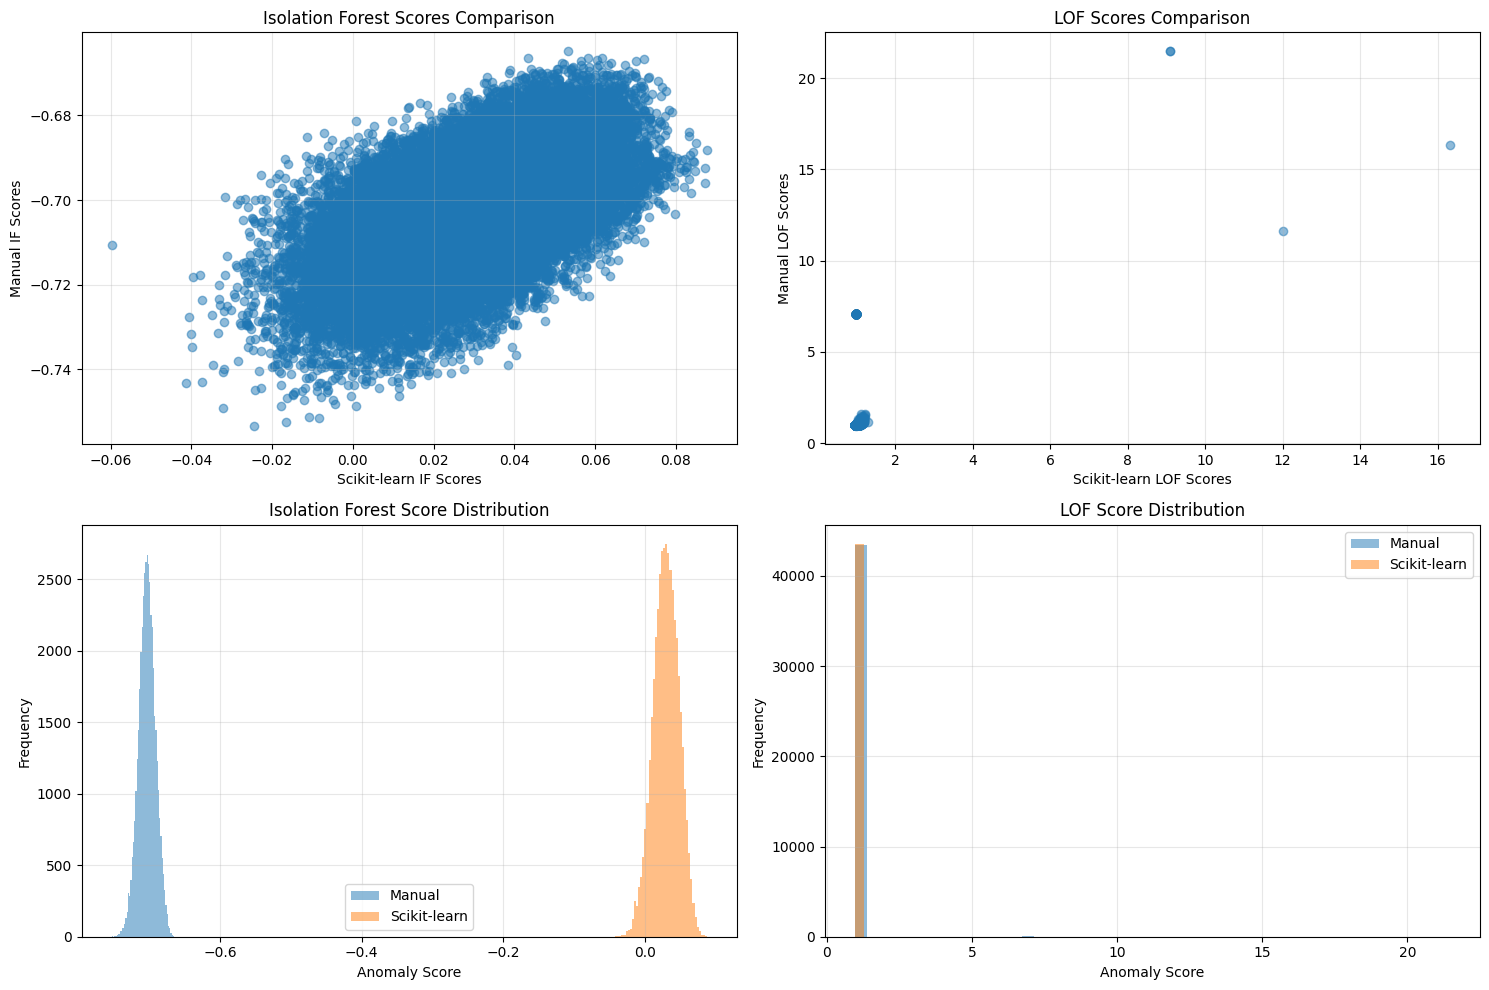

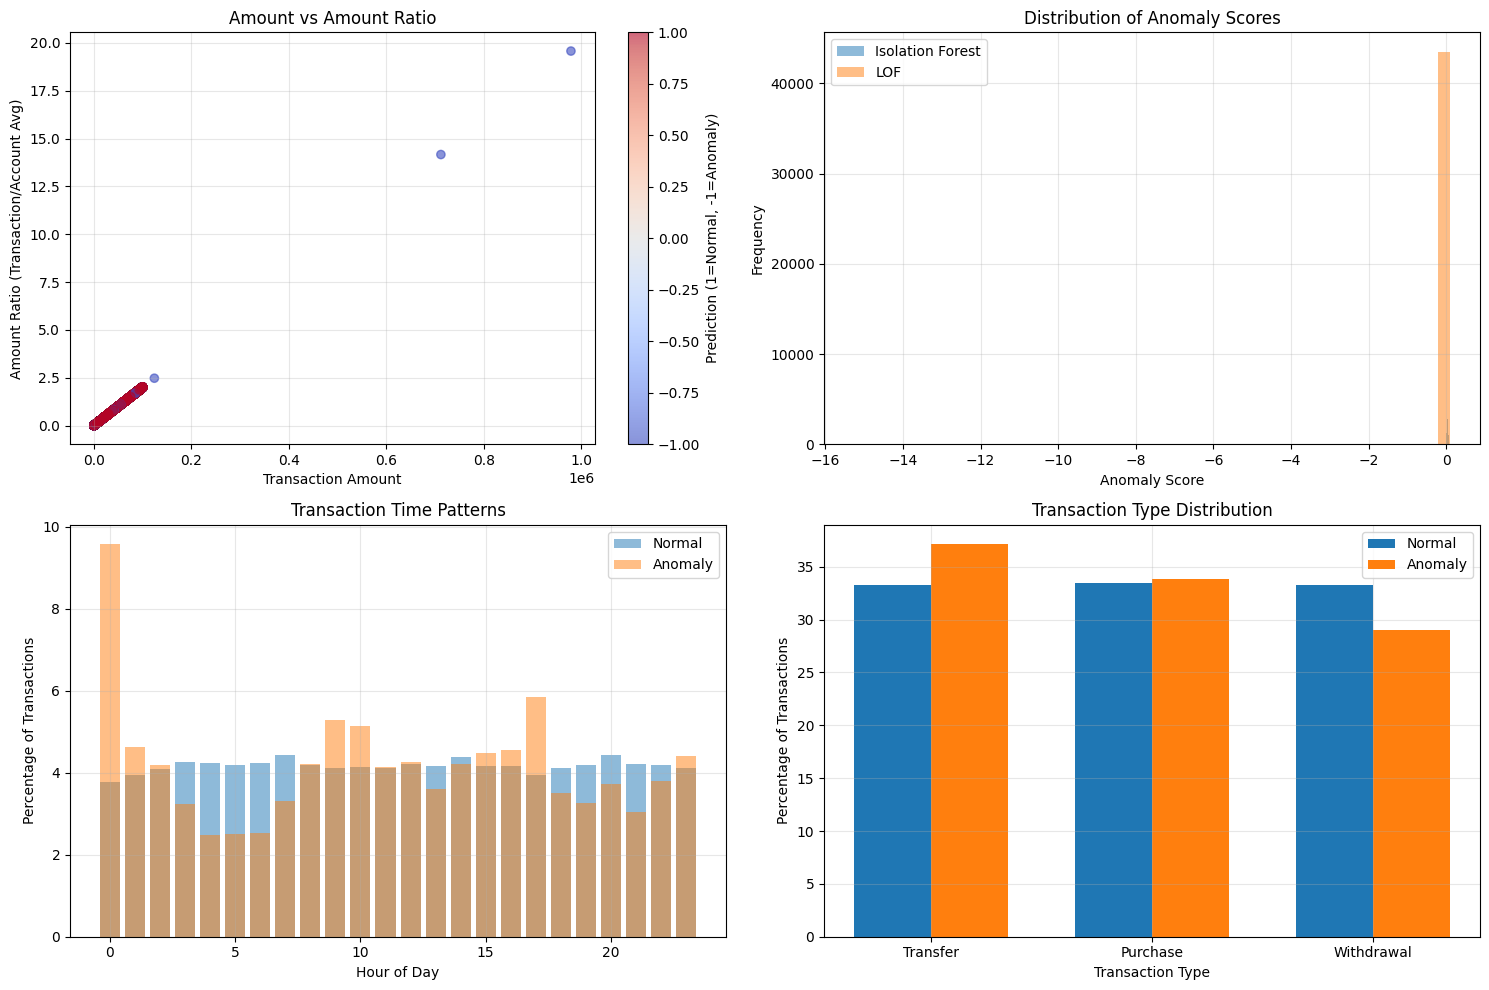

In [ ]:
# This conditional statement checks if the script is being run directly (not imported)
if __name__ == "__main__":
    # Execute the main function with your dataset
    results = main('financial_anomaly_data.csv')

    # Print a final message to confirm execution completed
    print("\nExecution completed successfully!")
    print("Check the 'anomaly_detection_results.png' file for visualizations.")